In [1]:
!pip install -U scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which 

In [2]:
import pandas as pd #lets us load our customer data from the .csv file into a clean, table-like structure called a DataFrame
import numpy as np # NumPy handles the numbers inside the data table it. It works behind the scenes to make mathematical operations on our data fast and efficient. We need it for tasks like calculating the median TotalCharges
import joblib #can save our fully trained model(.dump), loads the saved model from the file (.load) 
from sklearn.model_selection import train_test_split #A function from the scikit-learn library (sklearn) that splits our data into two parts.
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # These are data "cleaners" or "preprocessors" since ML model only understands numbers not text it converts data into it.
from sklearn.compose import ColumnTransformer # An organizer or a manager for our preprocessing tools suppose We have numerical columns that need StandardScaler and categorical columns(text data) that need OneHotEncoder. The ColumnTransformer is a tool that lets us apply the right transformation to the right column automatically. It keeps everything neat and organized.
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE #Synthetic Minority Over-sampling TEchnique, SMOTE creates new, synthetic examples of the minority class from the dataset (the "Churn" customers). It's like photocopying the few "Churn" examples so the model has a balanced view not get  baised to learn to say not churn.
from imblearn.pipeline import Pipeline as ImbPipeline #A pipeline is like an assembly line for our entire process. It chains all our steps together in the correct order
from sklearn.metrics import classification_report, ConfusionMatrixDisplay #classification_report: Gives us key metrics like precision and recall, which tell us how accurate the model is for predicting both "Churn" and "No Churn."ConfusionMatrixDisplay: Creates a visual grid that shows us exactly where the model was right and where it was wrong.
import matplotlib.pyplot as plt # The primary library for creating charts and plots in Python. We use it to actually draw the confusion matrix plot that ConfusionMatrixDisplay creates
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
print("Libraries imported!")

Libraries imported!


In [3]:
# Loading data
file_path = '/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path) # geting the data out of the file and into a format(smart spreadsheet) that Python can work with. A DataFrame(df) is the perfect tool for this, allowing us to easily view and manipulate the data with code.

# Convert TotalCharges from text to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Droped the 'customerID' column cause of no predective value
df.drop('customerID', axis=1, inplace=True)

# filling not available(fillna) in TotalCharges with the median
median_total_charges = df['TotalCharges'].median()
df.fillna({'TotalCharges': median_total_charges}, inplace=True)

# replacing the target variable 'Churn' with 1 or 0 intead of yes and no 
encoder = LabelEncoder()
df['Churn'] = encoder.fit_transform(df['Churn']) # fit assings 1 and 0 transform replaces yes and no with 1 and 0

print("loaded and cleaned.")
df.head()

loaded and cleaned.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [4]:
# Preprocessing and Model Pipeline

# splitting dataset in features X and target y
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist() # selecting columns with text i.e. data type object fr pd

# transformers
cat_transformer = OneHotEncoder(handle_unknown='ignore', drop='first') # transforms text to numbers, k coloumns for k categories,in future if a new category is added it will ignore and drops the first column as its redundant basically if its not anything else then its the first coloumn

# Create the preprocessor
preprocessor = ColumnTransformer( # this is a class from scikit learn which applies our intended tranformations
    transformers=[
        ('cat', cat_transformer, categorical_cols) # tranform the categorical_columns acc to cat_transformer
    ],
    remainder='passthrough' # let the remaining colums to pass through if any
)

# Build the final model pipeline with SMOTE
model_pipeline = ImbPipeline(steps=[ #imbpipeline from the imbalanced-learn library ensures every piece of data goes through a specific sequence of stations in the correct order. also knonws how to work with smote.
    ('preprocessor', preprocessor), # nickname for this step which is preprocessor to get data cleaned
    ('smote', SMOTE(random_state=42)),# smote checks for imbalance and balances it with synthetic data same every time since we specified type 42
    ('classifier', RandomForestClassifier(random_state=42)) # after that our algo is used on data. always use the exact same random starting point for consistency and only try a 1000 times to find the best possible curve
])                                                   

print("Model pipeline constructed successfully.")

Model pipeline constructed successfully.


Training the model...
Model training complete.

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1035
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Confusion Matrix:


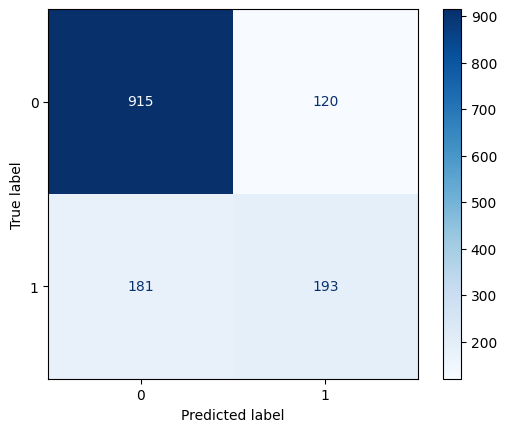


Pipeline saved successfully to '/kaggle/working/churn_prediction_pipeline.joblib'


In [5]:
# Train, Evaluate, and Save Model

# Spliting the dataset
X_train, X_test, y_train, y_test = train_test_split( #scikit learn fucntion train test split size 0.2 means hold back 20% for test also this function always returns data in same order x train,test,y train test
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Training the model
print("Training the model...")
model_pipeline.fit(X_train, y_train) # .fit() is a fucntion for all scikit learn objects
print("Model training complete.")

# Making predictions and evaluate
y_pred = model_pipeline.predict(X_test) #since model is trained now we pass the new unseen test data to get predictions
print("\nClassification Report:")
print(classification_report(y_test, y_pred)) # It then compares them and returns a neatly formatted text report with key performance metrics like precision, recall, and f1-score, function from the scikit-learn library Its job is to act as a "grading tool."

# Display the confusion matrix
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test, cmap='Blues') # class method from the scikit-learn library.
plt.show()

# Save the final pipeline.
joblib.dump(model_pipeline, 'churn_prediction_pipeline.joblib')
print("\nPipeline saved successfully to '/kaggle/working/churn_prediction_pipeline.joblib'")

In [6]:
# Loading Saved Model and Making a Sample Prediction

# Load the saved pipeline from the output directory
loaded_pipeline = joblib.load('churn_prediction_pipeline.joblib') # this pipeline is already trained and ready to predict on new data

# sample customer (as a dictionary)
sample_customer = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 2,
    'PhoneService': 'No',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'No',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 55.5,
    'TotalCharges': 5000.0
}

# Convert the dictionary to a DataFrame for prediction
sample_df = pd.DataFrame([sample_customer])

# Use the loaded pipeline to predict
prediction = loaded_pipeline.predict(sample_df)
prediction_proba = loaded_pipeline.predict_proba(sample_df)

# Display the result
print("--- Prediction for Sample Customer ---")
if prediction[0] == 1: # scikit learn always return answer in array if tht answer is one likely to churn
    print("Prediction: LIKELY to Churn")
else:
    print("Prediction: UNLIKELY to Churn")

print(f"Confidence (No Churn): {prediction_proba[0][0]:.2%}") # the probalities are also and array inside of our answer array
print(f"Confidence (Churn): {prediction_proba[0][1]:.2%}") # from the answer array first answer 2nd value is churn prob *100 (.2%)

--- Prediction for Sample Customer ---
Prediction: UNLIKELY to Churn
Confidence (No Churn): 54.00%
Confidence (Churn): 46.00%
